In [1]:
%matplotlib inline

import datetime
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import pandas as pd
import s3fs
import fsspec
import dask
from dask.distributed import performance_report, Client, progress


In [2]:
client = Client()
client

2022-10-12 17:27:02,070 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/b_/gxd85x_n4jv7sxtvcc1sv46c0000gp/T/dask-worker-space/worker-x8iqnsww', purging
2022-10-12 17:27:02,071 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/b_/gxd85x_n4jv7sxtvcc1sv46c0000gp/T/dask-worker-space/worker-dzuacdbi', purging
2022-10-12 17:27:02,071 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/b_/gxd85x_n4jv7sxtvcc1sv46c0000gp/T/dask-worker-space/worker-j_p9a9eu', purging
2022-10-12 17:27:02,071 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/b_/gxd85x_n4jv7sxtvcc1sv46c0000gp/T/dask-worker-space/worker-s5c5qzor', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:65329,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:65349,Total threads: 2
Dashboard: http://127.0.0.1:65353/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:65333,


# Problem 1

### Create SST Dataset

In [3]:
base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/'
base_url2 = '/e5.moda.an.sfc.128_034_sstk.ll025sc.'
base_url3 = '.nc'

# period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

file_list=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name
    single_file=(base_url+year+base_url2+month+'_'+month2+base_url3)
    
    file_list.append(single_file)


In [4]:
# file_list

In [5]:
ds = xr.open_mfdataset(file_list, chunks={'time': '100MB'}).sel(latitude=slice(65, -65, 1),longitude=slice(120, 300, 1)).compute()

In [6]:
# ds

In [6]:
gb = ds.SSTK.groupby('time.month')
gb

DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

In [7]:
anom = gb - gb.mean(dim='time')

In [9]:
# anom

#### Mask data

In [8]:
mask_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc'
mask = xr.open_dataset(mask_url).sel(latitude=slice(65, -65, 1),longitude=slice(120, 300, 1)).compute()

In [9]:
mask_drop = mask.squeeze('time')
mask_time = mask_drop.expand_dims(time=anom.time)

In [10]:
mask_SST = anom.where(mask_time.LSM==0., np.nan)

In [11]:
# mask_SST.sel(time='2002-12-01', method='nearest').plot()

In [12]:
# mask_SST

### Create Precip Dataset

In [13]:
base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/'
base_url2 = '/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.'
base_url3 = '.nc'

# period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

file_list=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name
    single_file=(base_url+year+base_url2+month+'_'+month2+base_url3)
    
    file_list.append(single_file)

In [14]:
# file_list

In [15]:
ds_p = xr.open_mfdataset(file_list, chunks={'time': '100MB'}).sel(latitude=slice(65, -65, 1),longitude=slice(120, 300, 1)).compute()

In [18]:
# ds_p

In [16]:
group_p = ds_p.TP.groupby('time.month')
group_p

DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

In [17]:
precip_anom = group_p - group_p.mean(dim='time')

In [21]:
# precip_anom

#### Masked Data

In [18]:
mask_precip = precip_anom.where(mask_time.LSM==0., np.nan)

In [23]:
# mask_precip.sel(time='2000-12-01', method='nearest').plot(size=5)

In [24]:
# mask_precip

In [25]:
# anomalies = xr.DataArray()


# Problem 2

### Deseasonalize

In [26]:
# mask_SST.sel(latitude=0, longitude=200).plot()

#### Idea 1

In [27]:
#deseason = mask_SST.resample(time='AS').mean(dim='time') - mask_SST 

In [19]:
deseason_sst = mask_SST.groupby('time.month') - mask_SST.groupby('time.month').mean(dim='time')
deseason_precip = mask_precip.groupby('time.month') - mask_precip.groupby('time.month').mean(dim='time')

In [29]:
# deseason_sst

In [30]:
# deseason_sst.sel(latitude=0, longitude=200).plot()

### Detrend

In [31]:
# # Detrend using the second deseason method...
# fig = plt.figure(figsize=(15, 7))
# layout = (3, 2)
# fit_ax = plt.subplot2grid(layout, (2, 0), colspan=2)

# X = [i for i in range(0, len(deseason2))]
# X = np.reshape(X, (len(X), 1))
# y = deseason2.values
# model = LinearRegression()
# model.fit(X, y)
# # calculate trend
# trend = model.predict(X)
# fit_ax.plot(trend)
# fit_ax.set_title("Trend fitted by linear regression")

# # test = deseason.sel(latitude=0, longitude=200)

# # model = LinearRegression().fit(test, test.time)

In [20]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

# -- Running mean
#ranm_sst = deseason_sst.rolling(time=12, center=True).mean('time')
detrend_sst = detrend_dim(deseason_sst,'time',1)

#ranm_precip = deseason_precip.rolling(time=12, center=True).mean('time')
detrend_precip = detrend_dim(deseason_precip,'time',1)

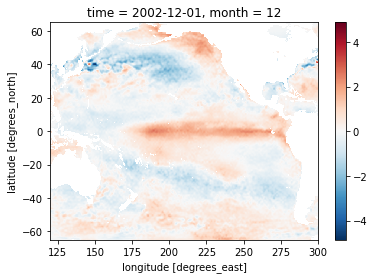

In [21]:
detrend_sst.sel(time='2002-12-01', method='nearest').plot()

In [22]:
# detrend_sst.sel(latitude=0, longitude=200).plot()

In [23]:
detrend_sst

<xarray.DataArray (time: 516, latitude: 521, longitude: 721)>
array([[[        nan,         nan,         nan, ...,  0.31807601,
          0.31556352,  0.31322335],
        [        nan,         nan,         nan, ...,  0.29584003,
          0.28868674,  0.27951726],
        [        nan,         nan,         nan, ...,  0.3134674 ,
          0.29667113,  0.27996806],
        ...,
        [-0.24131322, -0.23622279, -0.23153092, ...,         nan,
                 nan,         nan],
        [-0.80226542, -0.78285236, -0.76398748, ...,         nan,
                 nan,         nan],
        [-0.75165078, -0.74684634, -0.75741412, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,  0.3244674 ,
          0.32687277,  0.3293594 ],
        [        nan,         nan,         nan, ...,  0.3073405 ,
          0.30618257,  0.30229113],
        [        nan,         nan,         nan, ...,  0.32840106,
          0.31625276,  0.30412953],
...
        [-0.07840428, -0.08667509, -0.09504698, ...,         nan,
                 nan,         nan],
        [-0.05915139, -0.06569   , -0.07218003, ...,         nan,
                 nan,         nan],
        [-0.08134029, -0.08642298, -0.09010383, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ..., -0.23255344,
         -0.26547001, -0.29917209],
        [        nan,         nan,         nan, ..., -0.23168649,
         -0.25523814, -0.27588764],
        [        nan,         nan,         nan, ..., -0.25501658,
         -0.26363263, -0.27206937],
        ...,
        [-0.16954765, -0.14979311, -0.13100271, ...,         nan,
                 nan,         nan],
        [-0.35575586, -0.34730343, -0.33862071, ...,         nan,
                 nan,         nan],
        [-0.22475563, -0.22322422, -0.22939468, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

### Standardize

In [36]:
# # Standardize????

# long_mean = detrend.mean()
# standard = detrend.std()

# standardize = (detrend - long_mean)/standard
# standardize.plot()

In [24]:
long_mean_sst = detrend_sst.groupby('time.month').mean(dim='time')
std_sst = detrend_sst.groupby('time.month').std(dim='time')
standardize_sst = (detrend_sst.groupby('time.month') - long_mean_sst)/std_sst
standardize_sst

<xarray.DataArray (time: 516, latitude: 521, longitude: 721, month: 12)>
array([[[[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         ...,
         [  1.65651349,   1.6471645 ,   1.65003182, ...,   0.59875549,
            0.77062112,   1.68409143],
         [  1.59786055,   1.62046041,   1.62303656, ...,   0.57687328,
            0.75428811,   1.5251864 ],
         [  1.52052848,   1.59468007,   1.59500647, ...,   0.55116995,
            0.72970482,   1.34631342]],

        [[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
...
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan]],

        [[ -0.44963956,  -0.41278869,  -0.574897  , ...,  -4.76526595,
           -4.6525664 ,  -1.34758882],
         [ -0.44455192,  -0.4133647 ,  -0.57250632, ...,  -4.47456219,
           -4.33267296,  -1.32466763],
         [ -0.44705198,  -0.42511505,  -0.59450403, ...,  -4.40735546,
           -4.27394118,  -1.33127447],
         ...,
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan]]]])
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [25]:
long_mean_precip = detrend_precip.groupby('time.month').mean(dim='time')

In [26]:
std_precip = detrend_precip.groupby('time.month').std(dim='time')

In [27]:
s1 = detrend_precip.groupby('time.month') - long_mean_precip

In [41]:
standardize_precip = s1/std_precip

: 

: 

In [41]:
#standardize_precip = (detrend_precip.groupby('time.month') - long_mean_precip)/std_precip

: 

: 

In [38]:
long_mean_precip = detrend_precip.groupby('time.month').mean(dim='time')
std_precip = detrend_precip.groupby('time.month').std(dim='time')
# standardize_precip = (detrend_precip.groupby('time.month') - long_mean_precip)/std_precip
# standardize_precip

standardize_precip = xr.apply_ufunc(lambda x, m, s: (x - m) / s,
                                    detrend_precip.groupby('time.month'),
                                    long_mean_precip, std_precip)


: 

: 

In [47]:
standardize_sst

<xarray.DataArray (time: 516, latitude: 521, longitude: 721, month: 12)>
array([[[[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         ...,
         [  1.65651349,   1.6471645 ,   1.65003182, ...,   0.59875549,
            0.77062112,   1.68409143],
         [  1.59786055,   1.62046041,   1.62303656, ...,   0.57687328,
            0.75428811,   1.5251864 ],
         [  1.52052848,   1.59468007,   1.59500647, ...,   0.55116995,
            0.72970482,   1.34631342]],

        [[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
...
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan]],

        [[ -0.44963956,  -0.41278869,  -0.574897  , ...,  -4.76526595,
           -4.6525664 ,  -1.34758882],
         [ -0.44455192,  -0.4133647 ,  -0.57250632, ...,  -4.47456219,
           -4.33267296,  -1.32466763],
         [ -0.44705198,  -0.42511505,  -0.59450403, ...,  -4.40735546,
           -4.27394118,  -1.33127447],
         ...,
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan]]]])
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [54]:
standardize_sst_drop = standardize_sst.drop('month')

In [55]:
standardize_sst_drop

<xarray.DataArray (time: 516, latitude: 521, longitude: 721, month: 12)>
array([[[[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         ...,
         [  1.65651349,   1.6471645 ,   1.65003182, ...,   0.59875549,
            0.77062112,   1.68409143],
         [  1.59786055,   1.62046041,   1.62303656, ...,   0.57687328,
            0.75428811,   1.5251864 ],
         [  1.52052848,   1.59468007,   1.59500647, ...,   0.55116995,
            0.72970482,   1.34631342]],

        [[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
...
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan]],

        [[ -0.44963956,  -0.41278869,  -0.574897  , ...,  -4.76526595,
           -4.6525664 ,  -1.34758882],
         [ -0.44455192,  -0.4133647 ,  -0.57250632, ...,  -4.47456219,
           -4.33267296,  -1.32466763],
         [ -0.44705198,  -0.42511505,  -0.59450403, ...,  -4.40735546,
           -4.27394118,  -1.33127447],
         ...,
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan]]]])
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Dimensions without coordinates: month

(array([4.000000e+00, 0.000000e+00, 0.000000e+00, 4.000000e+00,
        6.000000e+00, 1.000000e+00, 1.900000e+01, 1.000000e+02,
        5.035100e+04, 3.380483e+06]),
 array([-272.86901322, -242.80362151, -212.7382298 , -182.67283809,
        -152.60744638, -122.54205467,  -92.47666296,  -62.41127125,
         -32.34587954,   -2.28048783,   27.78490388]),
 <BarContainer object of 10 artists>)

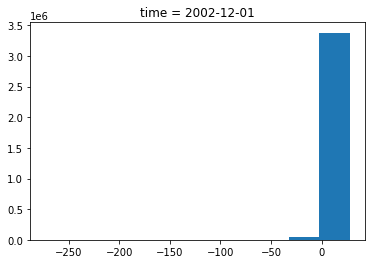

In [41]:
standardize_sst_drop.sel(time='2002-12-01', method='nearest').plot()

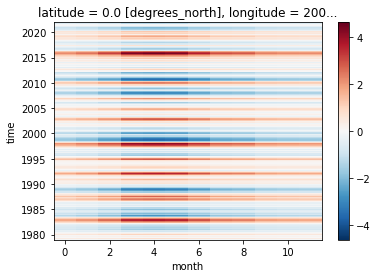

In [42]:
standardize_sst_drop.sel(latitude=0, longitude=200).plot()

# Problem 3

In [48]:
from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [56]:
# Eof only works with original anomaly dataset, won't work after standardizing for some reason...

In [50]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(anom.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(anom, weights=wgts)

In [52]:
# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
# eof1 = solver.eofsAsCorrelation(neofs=2)
# pc1 = solver.pcs(npcs=2, pcscaling=1)

eofs = solver.eofs(neofs=5)

In [54]:
eofs

<xarray.DataArray 'eofs' (mode: 5, latitude: 521, longitude: 721)>
array([[[            nan,             nan,             nan, ...,
          5.06283948e-04,  5.19868161e-04,  5.33274957e-04],
        [            nan,             nan,             nan, ...,
          5.19194698e-04,  5.33458020e-04,  5.48682874e-04],
        [            nan,             nan,             nan, ...,
          5.49389399e-04,  5.67563460e-04,  5.85480127e-04],
        ...,
        [-1.30981221e-04, -1.21567275e-04, -1.11902336e-04, ...,
                     nan,             nan,             nan],
        [-1.19758319e-04, -1.12095564e-04, -1.04348728e-04, ...,
                     nan,             nan,             nan],
        [-5.88197981e-05, -5.20251306e-05, -4.61451164e-05, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
         -1.08670560e-03, -1.09559449e-03, -1.10482029e-03],
        [            nan,             nan,             nan, ...,
         -1.02201512e-03, -1.01957121e-03, -1.00663153e-03],
        [            nan,             nan,             nan, ...,
         -1.10755244e-03, -1.06256956e-03, -1.01775187e-03],
...
                     nan,             nan,             nan],
        [-1.04447048e-04, -1.10121320e-04, -1.15740848e-04, ...,
                     nan,             nan,             nan],
        [-4.67649625e-05, -4.83416079e-05, -4.52762433e-05, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
         -4.64520126e-04, -5.18174493e-04, -5.73208847e-04],
        [            nan,             nan,             nan, ...,
         -5.62920992e-04, -5.61621040e-04, -5.68609685e-04],
        [            nan,             nan,             nan, ...,
         -5.61207009e-04, -5.90937270e-04, -6.20773702e-04],
        ...,
        [-1.57404720e-04, -1.58718831e-04, -1.59897128e-04, ...,
                     nan,             nan,             nan],
        [-6.90851375e-05, -7.77585010e-05, -8.61528169e-05, ...,
                     nan,             nan,             nan],
        [ 3.72377763e-05,  2.62861631e-05,  1.32812684e-05, ...,
                     nan,             nan,             nan]]],
      dtype=float32)
Coordinates:
  * mode       (mode) int64 0 1 2 3 4
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
Attributes:
    long_name:  empirical_orthogonal_functions

Text(0.5, 1.0, 'EOF1 expressed as correlation')

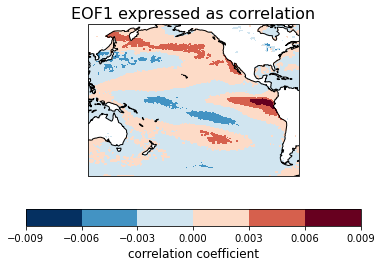

In [62]:
# Plot the leading EOF expressed as correlation in the Pacific domain.
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eofs[4].plot.contourf(ax=ax, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF1 expressed as correlation', fontsize=16)

In [1]:
client.close()

NameError: name 'client' is not defined